# Lithology Prediction

### Raw Data Exploration

* Show head (6 rows) of raw data
* Color map of lithology over longitude and latitude
* Histogram of lithology
* Missing part visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

% matplotlib inline

dfdata = pd.read_csv("data/train_clean.csv")
# sort dfdata based on longitude
dfdata = dfdata.sort_values("longitude")
dfdata.head()

,longitude,latitude,lithology,bathymetry,nitrate,oxygen,phosphate,productivity,salinity,silicate,temperature
0,-180,75,4,-231.0,NaN,8.552258,NaN,310.199677,31.165499,NaN,-0.878415
5962,-180,38,4,-5425.0,NaN,5.702333,NaN,427.678925,34.342628,NaN,15.691460
5757,-180,39,4,-5335.0,NaN,5.829761,NaN,497.673096,34.254448,NaN,14.695810
32077,-180,-55,4,-5287.0,NaN,6.456027,NaN,335.052032,34.125984,NaN,6.751073
5562,-180,40,4,-5241.0,NaN,5.968406,NaN,584.339844,34.158997,NaN,13.663589


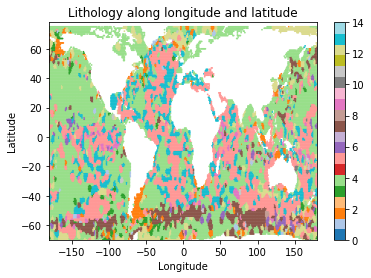

In [2]:
lon = dfdata["longitude"].values
lat = dfdata["latitude"].values
y = dfdata["lithology"].values

# plot lithology vesus longitude and latitude
def draw_global(lon, lat, y, title, cmap="tab20", vmin=0, vmax=14):
    sc = plt.scatter(lon, lat, s=0.5, c=y, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.xlim([-180, 180])
    plt.ylim([-70, 78])
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(sc)
    plt.show()
draw_global(lon, lat, y, "Lithology along longitude and latitude")

### Imbalanced Multiclass Classification
As we can see from the histogram of target lithology, the class distribution is not uniform. Some classes have large amount of samples whereas some classes have less samples. This enables model to cost less to predict those rare classes wrong. To fix this problem, we need to re-weight classes to obtain balanced classes.

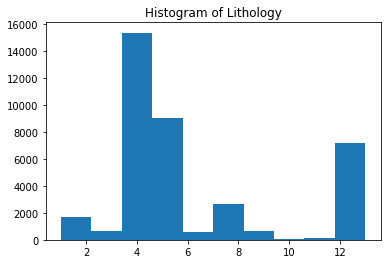

In [3]:
def draw_hist(y, title):
    # plot the histogram of lithology
    plt.hist(y)
    plt.title(title)
    plt.show()

draw_hist(y, "Histogram of Lithology")

### Keras - Neural Network Classification

We will deploy keras - a neural network library which is capable for running on top of Tensorflow.

In [4]:
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential, Model
from keras.callbacks import History
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight
warnings.simplefilter("ignore")

Using TensorFlow backend.


### Data preprocessing
* Normalize features X
* Onehot multiclass target Y

In [5]:
# obtain list of feature names
training_data = dfdata.copy()
target = "lithology"
features = list(training_data.columns)
features.remove(target)
features.remove("longitude")
features.remove("latitude")

# impute missing with mean
fill_dict = {}
for col in training_data:
    fill_dict[col] = np.mean(training_data[col])
training_data = training_data.fillna(value=fill_dict)

# extract X and Y
X = training_data[features].astype(float)
Y = training_data[target]

# standardize X
scaler = StandardScaler()
X = scaler.fit_transform(X)

# onehot target Y -> convert integers to dummy variables
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
dummy_Y = np_utils.to_categorical(Y)

# class reweighting for imbalanced class
weight = class_weight.compute_class_weight('balanced', np.unique(Y), Y)

### Construct neural network
The neural network has the following structure:
- Input layer
- Hidden layer 1: consists of 64 nerons
- Dropout layer : drop out 20% of nerons to avoid overfitting
- Hidden layer 2: consists of 64 nerons
- Dropout layer : drop out 20% of nerons to avoid overfitting
- Hidden layer 3: consists of 32 nerons
- Output layer

In [6]:
# fix random seed for reproducibility
seed = 0
np.random.seed(seed)

# parameters for hidden layers
activation = "relu"
dropout_ratio = 0.1
initializer = "random_uniform"
dropout_ratio = 0.2
numclass = dummy_Y.shape[1]
N, d = X.shape

# construct layers
inputs = Input(shape=(d,))
layer = Dense(64, activation=activation, kernel_initializer=initializer)(inputs)
layer = Dropout(dropout_ratio)(layer)
layer = Dense(64, activation=activation, kernel_initializer=initializer)(layer)
layer = Dropout(dropout_ratio)(layer)
layer = Dense(32, activation=activation, kernel_initializer=initializer)(layer)
prediction = Dense(numclass, activation="softmax")(layer)

# create model
model = Model(inputs=inputs, outputs=prediction)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                576       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 13)                429       
Total para

In [7]:
# parameters for training
epochs = 200
batch_size = 5
verbose = True

# use 5 fold cross validation without shuffle
kfold = KFold(n_splits=5, random_state=seed)

# training
prediction = np.zeros((N, numclass))
for train_ind, test_ind in kfold.split(X):
    train_X, train_Y = X[train_ind], dummy_Y[train_ind]
    model.fit(train_X, train_Y, epochs=epochs, batch_size=batch_size, verbose=verbose, class_weight=weight)
    mu = model.predict(X[test_ind])
    prediction[test_ind, :] = mu

Epoch 1/200
30439/30439 [==============================] - 6s 206us/step - loss: 1.5101 - acc: 0.4659
Epoch 2/200
30439/30439 [==============================] - 6s 200us/step - loss: 1.4267 - acc: 0.4960
Epoch 3/200
30439/30439 [==============================] - 6s 205us/step - loss: 1.3988 - acc: 0.5097
Epoch 4/200
30439/30439 [==============================] - 6s 205us/step - loss: 1.3796 - acc: 0.5140
Epoch 5/200
30439/30439 [==============================] - 6s 207us/step - loss: 1.3680 - acc: 0.5162
Epoch 6/200
30439/30439 [==============================] - 6s 203us/step - loss: 1.3586 - acc: 0.5198
Epoch 7/200
30439/30439 [==============================] - 6s 202us/step - loss: 1.3467 - acc: 0.5241
Epoch 8/200
30439/30439 [==============================] - 6s 200us/step - loss: 1.3396 - acc: 0.5232
Epoch 9/200
30439/30439 [==============================] - 6s 208us/step - loss: 1.3341 - acc: 0.5259
Epoch 10/200
30439/30439 [==============================] - 6s 201us/step - loss: 

30439/30439 [==============================] - 6s 196us/step - loss: 1.2234 - acc: 0.5555
Epoch 81/200
30439/30439 [==============================] - 6s 196us/step - loss: 1.2175 - acc: 0.5571
Epoch 82/200
30439/30439 [==============================] - 6s 194us/step - loss: 1.2203 - acc: 0.5548
Epoch 83/200
30439/30439 [==============================] - 6s 195us/step - loss: 1.2178 - acc: 0.5559
Epoch 84/200
30439/30439 [==============================] - 6s 196us/step - loss: 1.2233 - acc: 0.5555
Epoch 85/200
30439/30439 [==============================] - 6s 195us/step - loss: 1.2156 - acc: 0.5566
Epoch 86/200
30439/30439 [==============================] - 6s 194us/step - loss: 1.2228 - acc: 0.5570
Epoch 87/200
30439/30439 [==============================] - 6s 196us/step - loss: 1.2166 - acc: 0.5587
Epoch 88/200
30439/30439 [==============================] - 6s 197us/step - loss: 1.2225 - acc: 0.5570
Epoch 89/200
30439/30439 [==============================] - 6s 202us/step - loss: 1.21

30439/30439 [==============================] - 6s 197us/step - loss: 1.1984 - acc: 0.5678
Epoch 160/200
30439/30439 [==============================] - 6s 196us/step - loss: 1.2090 - acc: 0.5614
Epoch 161/200
30439/30439 [==============================] - 6s 197us/step - loss: 1.2029 - acc: 0.5646
Epoch 162/200
30439/30439 [==============================] - 6s 195us/step - loss: 1.1998 - acc: 0.5669
Epoch 163/200
30439/30439 [==============================] - 6s 199us/step - loss: 1.2018 - acc: 0.5661
Epoch 164/200
30439/30439 [==============================] - 6s 197us/step - loss: 1.2106 - acc: 0.5589
Epoch 165/200
30439/30439 [==============================] - 6s 197us/step - loss: 1.2086 - acc: 0.5646
Epoch 166/200
30439/30439 [==============================] - 6s 197us/step - loss: 1.2082 - acc: 0.5630
Epoch 167/200
30439/30439 [==============================] - 6s 196us/step - loss: 1.2010 - acc: 0.5635
Epoch 168/200
30439/30439 [==============================] - 6s 198us/step - l

30439/30439 [==============================] - 7s 227us/step - loss: 1.1778 - acc: 0.5887
Epoch 39/200
30439/30439 [==============================] - 6s 201us/step - loss: 1.1776 - acc: 0.5888
Epoch 40/200
30439/30439 [==============================] - 6s 202us/step - loss: 1.1778 - acc: 0.5856
Epoch 41/200
30439/30439 [==============================] - 6s 204us/step - loss: 1.1774 - acc: 0.5886
Epoch 42/200
30439/30439 [==============================] - 6s 200us/step - loss: 1.1720 - acc: 0.5887
Epoch 43/200
30439/30439 [==============================] - 6s 200us/step - loss: 1.1745 - acc: 0.5869
Epoch 44/200
30439/30439 [==============================] - 6s 193us/step - loss: 1.1752 - acc: 0.5903
Epoch 45/200
30439/30439 [==============================] - 6s 194us/step - loss: 1.1761 - acc: 0.5898
Epoch 46/200
30439/30439 [==============================] - 6s 200us/step - loss: 1.1805 - acc: 0.5882
Epoch 47/200
30439/30439 [==============================] - 6s 204us/step - loss: 1.17

30439/30439 [==============================] - 6s 196us/step - loss: 1.1571 - acc: 0.5925
Epoch 118/200
30439/30439 [==============================] - 6s 194us/step - loss: 1.1588 - acc: 0.5919
Epoch 119/200
30439/30439 [==============================] - 6s 194us/step - loss: 1.1647 - acc: 0.5914
Epoch 120/200
30439/30439 [==============================] - 6s 196us/step - loss: 1.1619 - acc: 0.5940
Epoch 121/200
30439/30439 [==============================] - 6s 195us/step - loss: 1.1666 - acc: 0.5909
Epoch 122/200
30439/30439 [==============================] - 6s 195us/step - loss: 1.1611 - acc: 0.5899
Epoch 123/200
30439/30439 [==============================] - 6s 194us/step - loss: 1.1559 - acc: 0.5937
Epoch 124/200
30439/30439 [==============================] - 6s 194us/step - loss: 1.1591 - acc: 0.5927
Epoch 125/200
30439/30439 [==============================] - 6s 197us/step - loss: 1.1583 - acc: 0.5926
Epoch 126/200
30439/30439 [==============================] - 6s 195us/step - l

30439/30439 [==============================] - 6s 193us/step - loss: 1.1570 - acc: 0.5961
Epoch 196/200
30439/30439 [==============================] - 6s 195us/step - loss: 1.1542 - acc: 0.5942
Epoch 197/200
30439/30439 [==============================] - 6s 194us/step - loss: 1.1634 - acc: 0.5933
Epoch 198/200
30439/30439 [==============================] - 6s 194us/step - loss: 1.1579 - acc: 0.5935
Epoch 199/200
30439/30439 [==============================] - 6s 197us/step - loss: 1.1503 - acc: 0.5963
Epoch 200/200
30439/30439 [==============================] - 6s 194us/step - loss: 1.1532 - acc: 0.5966
Epoch 1/200
30439/30439 [==============================] - 6s 194us/step - loss: 1.2583 - acc: 0.5683
Epoch 2/200
30439/30439 [==============================] - 6s 194us/step - loss: 1.2321 - acc: 0.5773
Epoch 3/200
30439/30439 [==============================] - 6s 195us/step - loss: 1.2249 - acc: 0.5779
Epoch 4/200
30439/30439 [==============================] - 6s 194us/step - loss: 1.2

30439/30439 [==============================] - 6s 201us/step - loss: 1.1718 - acc: 0.5901
Epoch 75/200
30439/30439 [==============================] - 6s 200us/step - loss: 1.1732 - acc: 0.5901
Epoch 76/200
30439/30439 [==============================] - 6s 195us/step - loss: 1.1660 - acc: 0.5952
Epoch 77/200
30439/30439 [==============================] - 6s 194us/step - loss: 1.1685 - acc: 0.5902
Epoch 78/200
30439/30439 [==============================] - 6s 194us/step - loss: 1.1681 - acc: 0.5913
Epoch 79/200
30439/30439 [==============================] - 6s 193us/step - loss: 1.1716 - acc: 0.5912
Epoch 80/200
30439/30439 [==============================] - 6s 193us/step - loss: 1.1682 - acc: 0.5916
Epoch 81/200
30439/30439 [==============================] - 6s 193us/step - loss: 1.1695 - acc: 0.5939
Epoch 82/200
30439/30439 [==============================] - 6s 194us/step - loss: 1.1741 - acc: 0.5924
Epoch 83/200
30439/30439 [==============================] - 6s 195us/step - loss: 1.17

30439/30439 [==============================] - 6s 195us/step - loss: 1.1635 - acc: 0.5924
Epoch 154/200
30439/30439 [==============================] - 6s 194us/step - loss: 1.1581 - acc: 0.5966
Epoch 155/200
30439/30439 [==============================] - 6s 195us/step - loss: 1.1561 - acc: 0.5983
Epoch 156/200
30439/30439 [==============================] - 6s 196us/step - loss: 1.1540 - acc: 0.5959
Epoch 157/200
30439/30439 [==============================] - 6s 195us/step - loss: 1.1560 - acc: 0.5981
Epoch 158/200
30439/30439 [==============================] - 6s 194us/step - loss: 1.1592 - acc: 0.5938
Epoch 159/200
30439/30439 [==============================] - 6s 195us/step - loss: 1.1621 - acc: 0.5979
Epoch 160/200
30439/30439 [==============================] - 6s 195us/step - loss: 1.1611 - acc: 0.5940
Epoch 161/200
30439/30439 [==============================] - 6s 196us/step - loss: 1.1651 - acc: 0.5939
Epoch 162/200
30439/30439 [==============================] - 6s 194us/step - l

30439/30439 [==============================] - 6s 195us/step - loss: 1.1625 - acc: 0.5902
Epoch 33/200
30439/30439 [==============================] - 6s 193us/step - loss: 1.1638 - acc: 0.5900
Epoch 34/200
30439/30439 [==============================] - 6s 194us/step - loss: 1.1627 - acc: 0.5892
Epoch 35/200
30439/30439 [==============================] - 6s 194us/step - loss: 1.1616 - acc: 0.5929
Epoch 36/200
30439/30439 [==============================] - 6s 195us/step - loss: 1.1663 - acc: 0.5919
Epoch 37/200
30439/30439 [==============================] - 6s 194us/step - loss: 1.1682 - acc: 0.5926
Epoch 38/200
30439/30439 [==============================] - 6s 194us/step - loss: 1.1615 - acc: 0.5896
Epoch 39/200
30439/30439 [==============================] - 6s 196us/step - loss: 1.1569 - acc: 0.5930
Epoch 40/200
30439/30439 [==============================] - 6s 195us/step - loss: 1.1573 - acc: 0.5895
Epoch 41/200
30439/30439 [==============================] - 6s 193us/step - loss: 1.15

30439/30439 [==============================] - 6s 194us/step - loss: 1.1483 - acc: 0.5958
Epoch 112/200
30439/30439 [==============================] - 6s 196us/step - loss: 1.1593 - acc: 0.5938
Epoch 113/200
30439/30439 [==============================] - 6s 196us/step - loss: 1.1511 - acc: 0.5969
Epoch 114/200
30439/30439 [==============================] - 6s 192us/step - loss: 1.1563 - acc: 0.5950
Epoch 115/200
30439/30439 [==============================] - 6s 194us/step - loss: 1.1480 - acc: 0.5968
Epoch 116/200
30439/30439 [==============================] - 6s 196us/step - loss: 1.1505 - acc: 0.5944
Epoch 117/200
30439/30439 [==============================] - 6s 194us/step - loss: 1.1495 - acc: 0.5935
Epoch 118/200
30439/30439 [==============================] - 6s 196us/step - loss: 1.1482 - acc: 0.5946
Epoch 119/200
30439/30439 [==============================] - 6s 195us/step - loss: 1.1512 - acc: 0.5979
Epoch 120/200
30439/30439 [==============================] - 6s 194us/step - l

30439/30439 [==============================] - 6s 196us/step - loss: 1.1480 - acc: 0.5949
Epoch 190/200
30439/30439 [==============================] - 6s 194us/step - loss: 1.1447 - acc: 0.5977
Epoch 191/200
30439/30439 [==============================] - 6s 196us/step - loss: 1.1558 - acc: 0.5968
Epoch 192/200
30439/30439 [==============================] - 6s 195us/step - loss: 1.1524 - acc: 0.5939
Epoch 193/200
30439/30439 [==============================] - 6s 195us/step - loss: 1.1574 - acc: 0.5950
Epoch 194/200
30439/30439 [==============================] - 6s 194us/step - loss: 1.1486 - acc: 0.5970
Epoch 195/200
30439/30439 [==============================] - 6s 196us/step - loss: 1.1533 - acc: 0.5997
Epoch 196/200
30439/30439 [==============================] - 6s 195us/step - loss: 1.1433 - acc: 0.5977
Epoch 197/200
30439/30439 [==============================] - 6s 195us/step - loss: 1.1462 - acc: 0.5999
Epoch 198/200
30439/30439 [==============================] - 6s 195us/step - l

30440/30440 [==============================] - 6s 194us/step - loss: 1.1236 - acc: 0.6018
Epoch 69/200
30440/30440 [==============================] - 6s 194us/step - loss: 1.1294 - acc: 0.6006
Epoch 70/200
30440/30440 [==============================] - 6s 193us/step - loss: 1.1296 - acc: 0.6027
Epoch 71/200
30440/30440 [==============================] - 6s 194us/step - loss: 1.1261 - acc: 0.6018
Epoch 72/200
30440/30440 [==============================] - 6s 195us/step - loss: 1.1287 - acc: 0.5992
Epoch 73/200
30440/30440 [==============================] - 6s 194us/step - loss: 1.1236 - acc: 0.5999
Epoch 74/200
30440/30440 [==============================] - 6s 197us/step - loss: 1.1234 - acc: 0.6014
Epoch 75/200
30440/30440 [==============================] - 6s 196us/step - loss: 1.1218 - acc: 0.6038
Epoch 76/200
30440/30440 [==============================] - 6s 195us/step - loss: 1.1253 - acc: 0.6001
Epoch 77/200
30440/30440 [==============================] - 6s 194us/step - loss: 1.12

30440/30440 [==============================] - 6s 196us/step - loss: 1.1114 - acc: 0.6037
Epoch 148/200
30440/30440 [==============================] - 6s 198us/step - loss: 1.1099 - acc: 0.6078
Epoch 149/200
30440/30440 [==============================] - 6s 195us/step - loss: 1.1198 - acc: 0.6020
Epoch 150/200
30440/30440 [==============================] - 6s 198us/step - loss: 1.1201 - acc: 0.5998
Epoch 151/200
30440/30440 [==============================] - 6s 195us/step - loss: 1.1141 - acc: 0.6032
Epoch 152/200
30440/30440 [==============================] - 6s 194us/step - loss: 1.1146 - acc: 0.6032
Epoch 153/200
30440/30440 [==============================] - 6s 196us/step - loss: 1.1203 - acc: 0.6044
Epoch 154/200
30440/30440 [==============================] - 6s 194us/step - loss: 1.1118 - acc: 0.6047
Epoch 155/200
30440/30440 [==============================] - 6s 193us/step - loss: 1.1197 - acc: 0.6005
Epoch 156/200
30440/30440 [==============================] - 6s 195us/step - l

### Validate

Accuracy = 0.48416515545743644


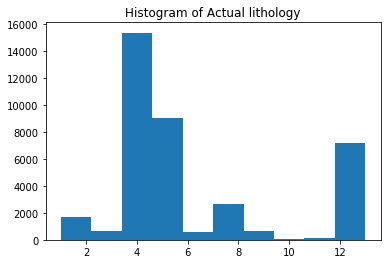

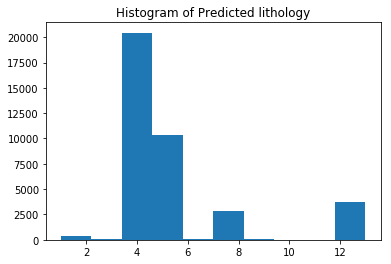

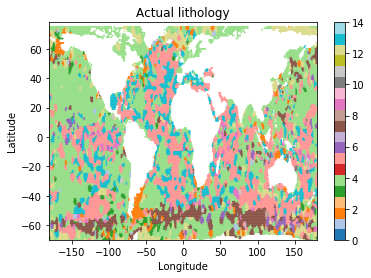

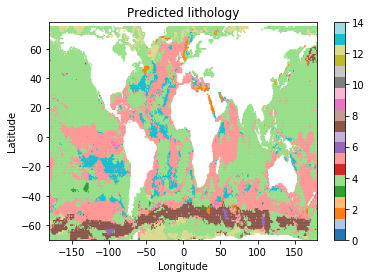

In [8]:
lon = dfdata["longitude"].values
lat = dfdata["latitude"].values

mean = np.argmax(prediction, axis=1)
print("Accuracy = {}".format(accuracy_score(Y, mean)))
draw_hist(Y + 1, "Histogram of Actual lithology")
draw_hist(mean + 1, "Histogram of Predicted lithology")
draw_global(lon, lat, Y + 1, "Actual lithology")
draw_global(lon, lat, mean + 1, "Predicted lithology")

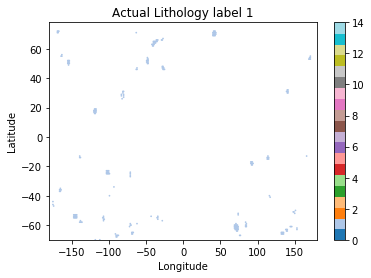

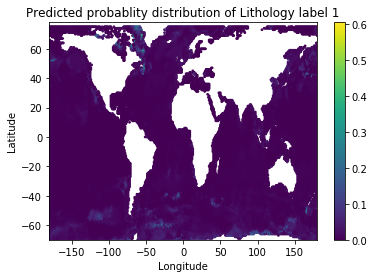

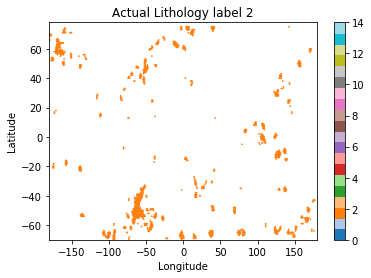

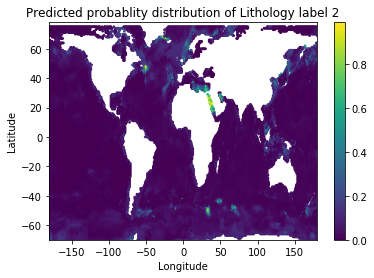

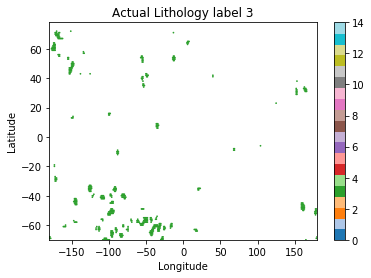

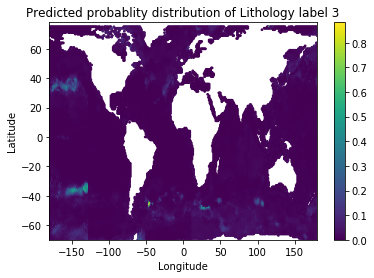

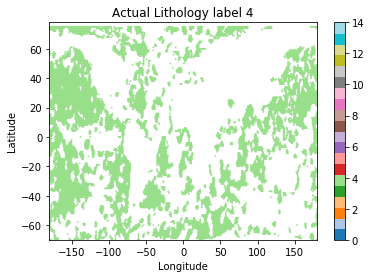

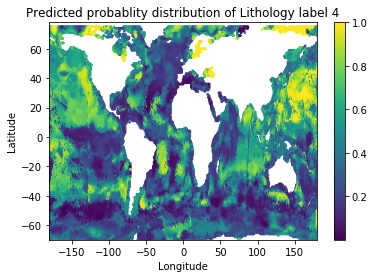

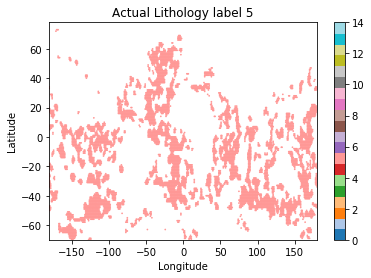

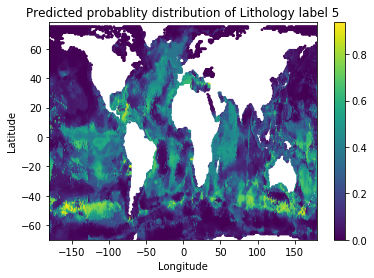

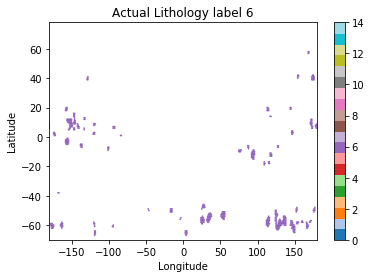

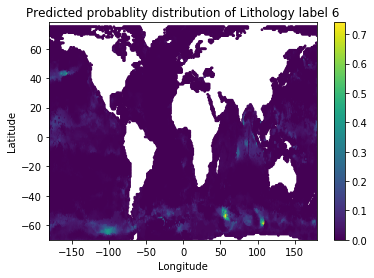

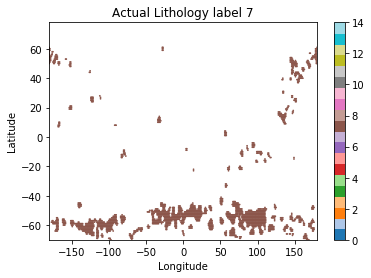

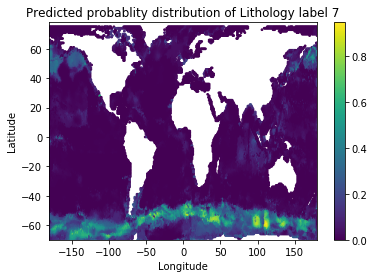

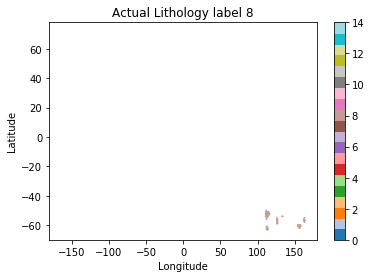

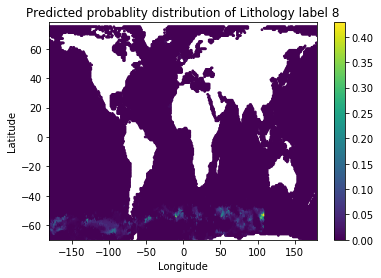

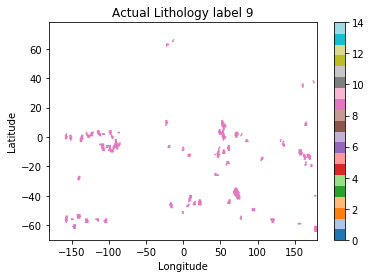

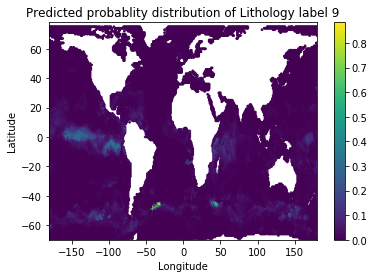

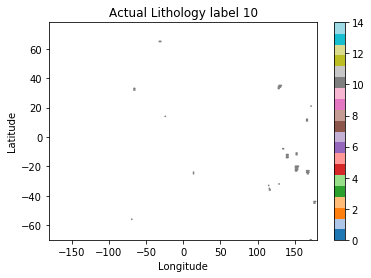

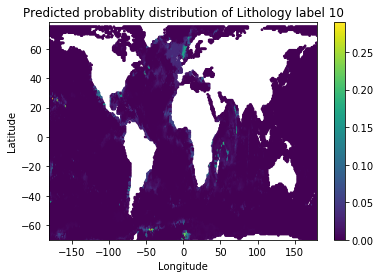

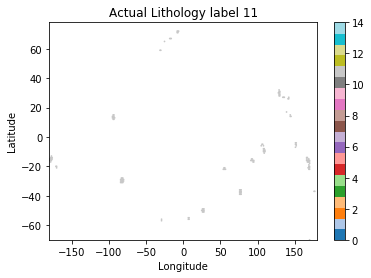

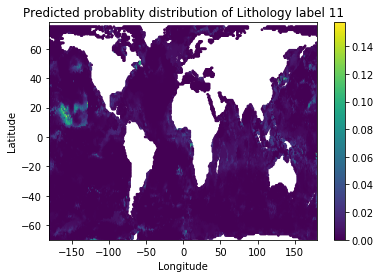

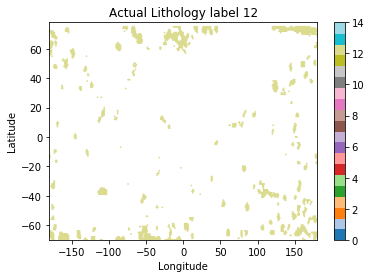

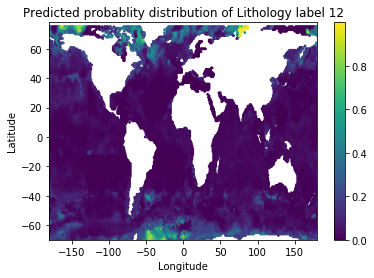

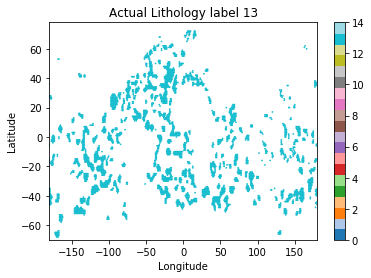

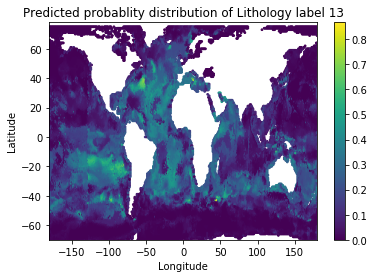

In [9]:
def draw_prob(lon, lat, p, title, size=3):
    sc = plt.scatter(lon, lat, s=size, c=p)
    plt.title(title)
    plt.xlim([-180, 180])
    plt.ylim([-70, 78])
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(sc)
    plt.show()
    plt.close()
    
for i in range(13):
    common_part = "Lithology label {}".format(i + 1)
    title_p = "Predicted probablity distribution of {}".format(common_part)
    title_y = "Actual {}".format(common_part)
    # find Y_ts whose label is i + 1 and plot
    index = Y == i
    thisY = Y[Y == i] + 1
    draw_global(lon[index], lat[index], y=thisY, title=title_y)
    # plot prob distribution
    draw_prob(lon, lat, p = prediction[:,i], title=title_p)